# ABS tutorial 05 (for template fitting)

## foreground cross-correlation models

following 

Planck 2018 results. XI. Polarized dust foregrounds
https://doi.org/10.1051/0004-6361/201832618

and

Polarized galactic synchrotron and dust emission and their correlation
https://doi.org/10.1088/1475-7516/2015/12/020

In [1]:
import numpy as np
import healpy as hp
import matplotlib
import abspy as ap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### import maps

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 7.643896 arcmin (0.002224 rad) 
-> fwhm is 18.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 5.095931 arcmin (0.001482 rad) 
-> fwhm is 12.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.038372 arcmin (0.000593 rad) 
-> fwhm is 4.800000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


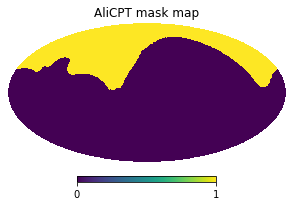

In [2]:
NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30 = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95 = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150 = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353 = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True)
map30 = hp.smoothing(map30+mapcmb,fwhm=fwhm[0])
map95 = hp.smoothing(map95+mapcmb,fwhm=fwhm[1])
map150 = hp.smoothing(map150+mapcmb,fwhm=fwhm[2])
map353 = hp.smoothing(map353+mapcmb,fwhm=fwhm[3])

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=False)

fig = matplotlib.pyplot.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(mask,title='AliCPT mask map',hold=True)

### initialize model with template maps

#### synchrotron model

- T mode

In [3]:
from abspy.tools.fg_models import syncmodel

FREQS = [30.,95.,150.,353.]
NMAP = 1
APOSCALE = 6.
PSBIN = 40

fullmap = dict()
fullmap[30] = map30[0].reshape(1,-1)

fullmap_fwhms = dict()
fullmap_fwhms[30] = fwhm[0]

s = syncmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=fullmap,template_fwhms=fullmap_fwhms)

bp = s.bandpower()
print (s.params)

{'beta_s': -2.5}


#### illustrate frequency dependencies

this would use the `bandpower` function, which takes a frequency list (in GHz) as input,
the return gives an array in shape 
```
(angular mode size, frequency size, frequency size)
```

- synchrotron

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{s,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_0} \right)^{\beta_s} $$

with Planck reference, $\nu_0 = 30$ GHz.

Text(0.5, 1.0, 'auto-corr. at angular mode')

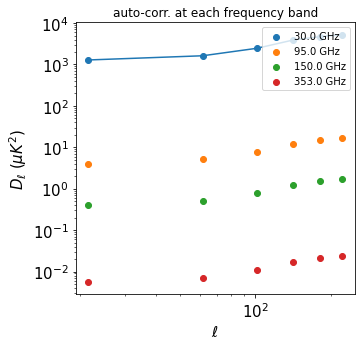

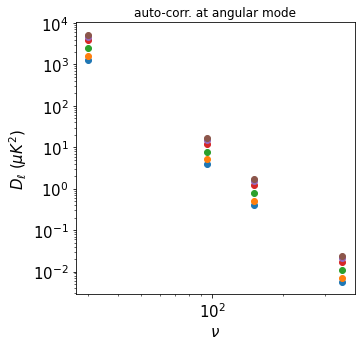

In [4]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

fiducial_dl = s.est.auto_t(map30[0].reshape(1,-1),fwhms=fwhm[0])
ax.plot(fiducial_dl[0],fiducial_dl[1])

for j in range(len(FREQS)):
    ax.scatter(s.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=1)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for i in range(len(s.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

- B mode

In [5]:
from abspy.tools.fg_models import syncmodel

FREQS = [30.,95.,150.,353.]
NMAP = 2
APOSCALE = 6.
PSBIN = 40

fullmap = dict()
fullmap[30] = map30[1:]

fullmap_fwhms = dict()
fullmap_fwhms[30] = fwhm[0]

s = syncmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=fullmap,template_fwhms=fullmap_fwhms)

bp = s.bandpower()
print (s.params)

{'beta_s': -2.5}


Text(0.5, 1.0, 'auto-corr. at angular mode')

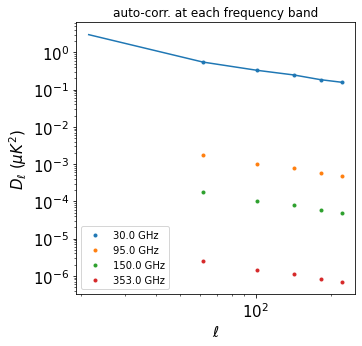

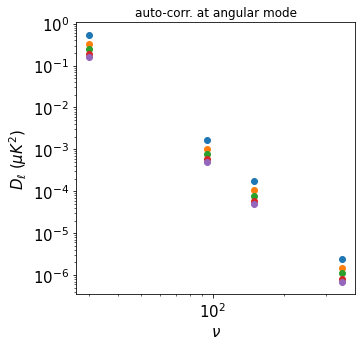

In [6]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

fiducial_dl = s.est.auto_eb(map30[1:],fwhms=fwhm[0])
ax.plot(fiducial_dl[0],fiducial_dl[2])

for j in range(len(FREQS)):
    ax.scatter(s.modes,bp[:,j,j],marker='.',label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for i in range(len(s.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

#### reset parameters

if a parameter is not pre-defined inside the `param_list`, then no update will be made

In [7]:
s.reset({'beta_s': -1., 'alpha_s': 2.})
print (s.param_list)
print (s.params)
print (s.param_range)

['beta_s']
{'beta_s': -1.0}
{'beta_s': [-5.0, 0.0]}


#### thermal dust model

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{d,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_0} \right)^{\beta_d-2} \frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)} \frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)}$$,

$$\left(\frac{\nu}{\nu_0}\right)^{{\beta_d}-2} \frac{B_\nu(T_d)}{B_{\nu_0}(T_d)} = \left( \frac{\nu}{\nu_0} \right)^{\beta_d+1} \frac{e^{h\nu_0/kT_d}-1}{e^{h\nu/kT_d}-1}$$

with Planck reference, we take $\nu_0=353$ GHz, $T_d = 19.6$ K.

- T mode

In [8]:
from abspy.tools.fg_models import dustmodel

FREQS = [30.,95.,150.,353.]
NMAP = 1
APOSCALE = 6.
PSBIN = 40

fullmap = dict()
fullmap[353] = map353[0].reshape(1,-1)

fullmap_fwhms = dict()
fullmap_fwhms[353] = fwhm[3]

d = dustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=fullmap,template_fwhms=fullmap_fwhms)

bp = d.bandpower()
print (d.param_list)
print (d.params)
print (d.param_range)

['beta_d']
{'beta_d': 2.5}
{'beta_d': [0.0, 5.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

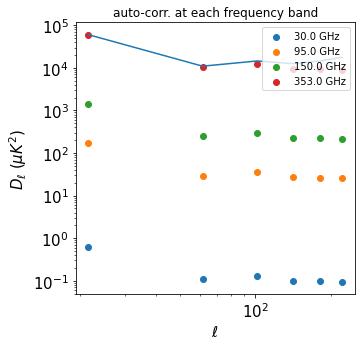

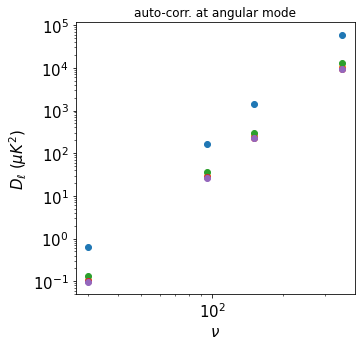

In [9]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

fiducial_dl = d.est.auto_t(map353[0].reshape(1,-1),fwhms=fwhm[0])
ax.plot(fiducial_dl[0],fiducial_dl[1])

for j in range(len(FREQS)):
    ax.scatter(d.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=1)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for i in range(len(s.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

- B mode

In [10]:
from abspy.tools.fg_models import syncmodel

FREQS = [30.,95.,150.,353.]
NMAP = 2
APOSCALE = 6.
PSBIN = 40

fullmap = dict()
fullmap[353] = map353[1:]

fullmap_fwhms = dict()
fullmap_fwhms[353] = fwhm[-1]

d = dustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=fullmap,template_fwhms=fullmap_fwhms)

bp = d.bandpower()
print (d.param_list)
print (d.params)
print (d.param_range)

['beta_d']
{'beta_d': 2.5}
{'beta_d': [0.0, 5.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

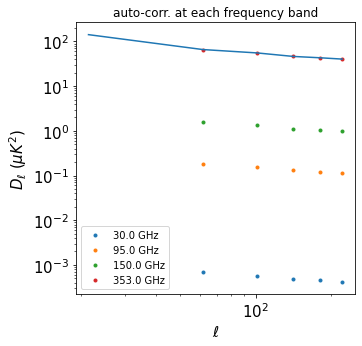

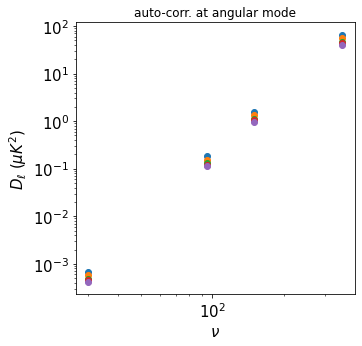

In [11]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

fiducial_dl = d.est.auto_eb(map353[1:],fwhms=fwhm[-1])
ax.plot(fiducial_dl[0],fiducial_dl[2])

for j in range(len(FREQS)):
    ax.scatter(d.modes,bp[:,j,j],marker='.',label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for i in range(len(s.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

#### synchrotron-dust correlated

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{s,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_{0s}} \right)^{\beta_s} + \mathcal{A}^{XX}_{d,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_{0d}} \right)^{\beta_d-2} \frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)} \frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)} + \rho^{XX} \sqrt{\mathcal{A}^{XX}_{s,\ell}\mathcal{A}^{XX}_{d,\ell}} \left( (\frac{\nu_1}{\nu_{0s}})^{\beta_s}(\frac{\nu_2}{\nu_{0d}})^{\beta_d-2}\frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)} + (\frac{\nu_2}{\nu_{0s}})^{\beta_s}(\frac{\nu_1}{\nu_{0d}})^{\beta_d-2}\frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)}\right)$$

with Planck reference, $\nu_{0s} = 30$ GHz, $\nu_{0d} = 353$ GHz.

- T mode

In [12]:
from abspy.tools.fg_models import syncdustmodel

FREQS = [30.,95.,150.,353.]
NMAP = 1
APOSCALE = 6.
PSBIN = 40

fullmap = dict()
fullmap[30] = map30[0].reshape(1,-1)
fullmap[353] = map353[0].reshape(1,-1)

fullmap_fwhms = dict()
fullmap_fwhms[30] = fwhm[0]
fullmap_fwhms[353] = fwhm[3]

c = syncdustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=fullmap,template_fwhms=fullmap_fwhms)

bp = c.bandpower()
print (c.param_list)
print (c.params)
print (c.param_range)

['beta_s', 'beta_d', 'rho']
{'beta_s': -2.5, 'beta_d': 2.5, 'rho': 0.0}
{'beta_s': [-5.0, 0.0], 'beta_d': [0.0, 5.0], 'rho': [-1.0, 1.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

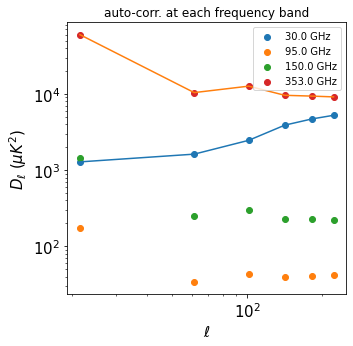

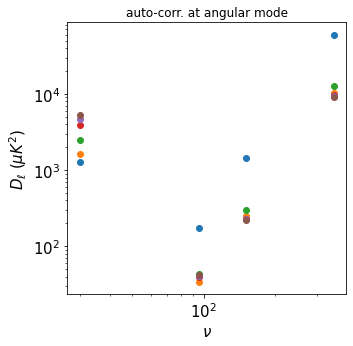

In [13]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

fiducial_dl = c.est.auto_t(map30[0].reshape(1,-1),fwhms=fwhm[0])
ax.plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = c.est.auto_t(map353[0].reshape(1,-1),fwhms=fwhm[-1])
ax.plot(fiducial_dl[0],fiducial_dl[1])

for j in range(len(FREQS)):
    ax.scatter(c.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=1)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for i in range(len(c.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

- B mode

In [14]:
FREQS = [30.,95.,150.,353.]
NMAP = 2
APOSCALE = 6.
PSBIN = 40

fullmap = dict()
fullmap[30] = map30[1:]
fullmap[353] = map353[1:]

fullmap_fwhms = dict()
fullmap_fwhms[30] = fwhm[0]
fullmap_fwhms[353] = fwhm[-1]

c = syncdustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=fullmap,template_fwhms=fullmap_fwhms)

bp = c.bandpower()
print (c.param_list)
print (c.params)
print (c.param_range)

['beta_s', 'beta_d', 'rho']
{'beta_s': -2.5, 'beta_d': 2.5, 'rho': 0.0}
{'beta_s': [-5.0, 0.0], 'beta_d': [0.0, 5.0], 'rho': [-1.0, 1.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

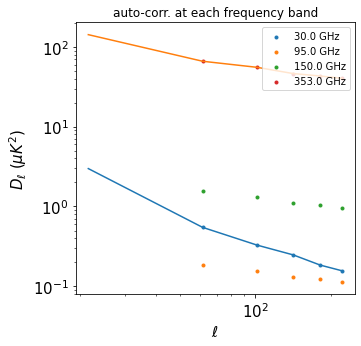

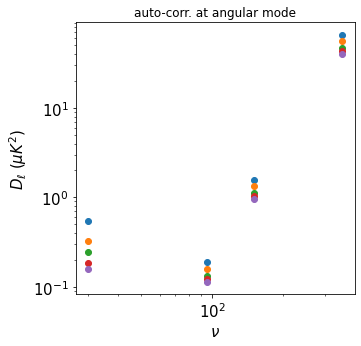

In [15]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

fiducial_dl = c.est.auto_eb(map30[1:],fwhms=fwhm[0])
ax.plot(fiducial_dl[0],fiducial_dl[2])
fiducial_dl = c.est.auto_eb(map353[1:],fwhms=fwhm[-1])
ax.plot(fiducial_dl[0],fiducial_dl[2])

for j in range(len(FREQS)):
    ax.scatter(c.modes,bp[:,j,j],marker='.',label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=1)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for i in range(len(c.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

In [16]:
from abspy.tools.bg_models import cmbmodel

FREQS = [30.,95.,150.,353.]
NMAP = 1
APOSCALE = 6.
PSBIN = 40

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)

bp = b.bandpower()
print ('\n param name list', b.param_list)
print ('\n param values', b.params)
print ('\n param range', b.param_range)


 param name list ['bp_c_T_21.5', 'bp_c_T_61.5', 'bp_c_T_101.5', 'bp_c_T_141.5', 'bp_c_T_181.5', 'bp_c_T_221.5']

 param values {'bp_c_T_21.5': 5000.0, 'bp_c_T_61.5': 5000.0, 'bp_c_T_101.5': 5000.0, 'bp_c_T_141.5': 5000.0, 'bp_c_T_181.5': 5000.0, 'bp_c_T_221.5': 5000.0}

 param range {'bp_c_T_21.5': [0.0, 10000.0], 'bp_c_T_61.5': [0.0, 10000.0], 'bp_c_T_101.5': [0.0, 10000.0], 'bp_c_T_141.5': [0.0, 10000.0], 'bp_c_T_181.5': [0.0, 10000.0], 'bp_c_T_221.5': [0.0, 10000.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

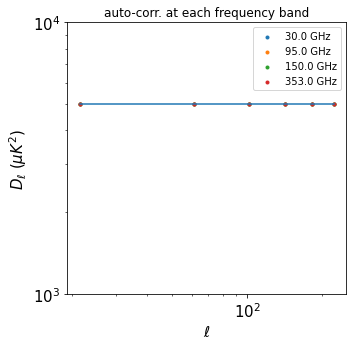

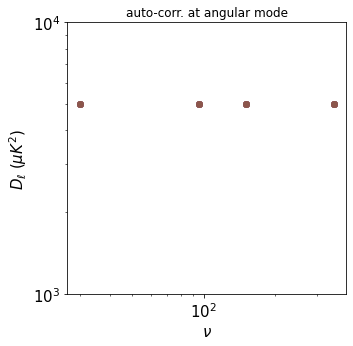

In [17]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.plot(b.modes,[0.5e+4]*len(b.modes))

for j in range(len(FREQS)):
    ax.scatter(b.modes,bp[:,j,j],marker='.',label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=1)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for i in range(len(b.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

In [18]:
FREQS = [30.,95.,150.,353.]
NMAP = 2
APOSCALE = 6.
PSBIN = 40

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)

bp = b.bandpower()
print ('\n param name list', b.param_list)
print ('\n param values', b.params)
print ('\n param range', b.param_range)


 param name list ['bp_c_B_61.5', 'bp_c_B_101.5', 'bp_c_B_141.5', 'bp_c_B_181.5', 'bp_c_B_221.5']

 param values {'bp_c_B_61.5': 5000.0, 'bp_c_B_101.5': 5000.0, 'bp_c_B_141.5': 5000.0, 'bp_c_B_181.5': 5000.0, 'bp_c_B_221.5': 5000.0}

 param range {'bp_c_B_61.5': [0.0, 10000.0], 'bp_c_B_101.5': [0.0, 10000.0], 'bp_c_B_141.5': [0.0, 10000.0], 'bp_c_B_181.5': [0.0, 10000.0], 'bp_c_B_221.5': [0.0, 10000.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

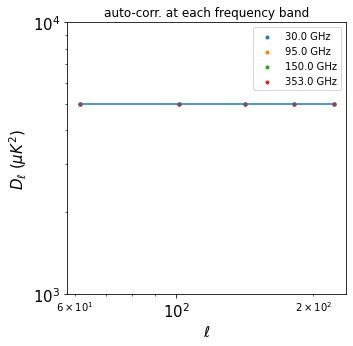

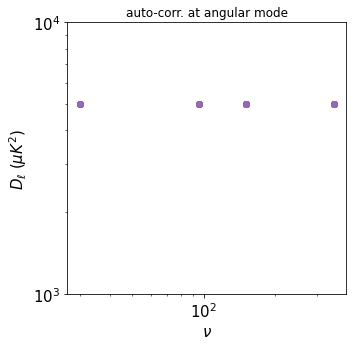

In [19]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.plot(b.modes,[0.5e+4]*len(b.modes))

for j in range(len(FREQS)):
    ax.scatter(b.modes,bp[:,j,j],marker='.',label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=1)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for i in range(len(b.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

end